In [1]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py
import warnings

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from keras.utils import to_categorical
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
sys.path.append('/home1/dscho/code/projects/manning_replication')
from helper_funcs import *
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, place_analysis, goldmine_behavior

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = {1: 2.05, 2: 3.125, 3: 6.45}

In [15]:
# Generate time cell firing patterns for
# simulated neurons with varying time field
# sizes and noise amounts
n_trials = 36
n_timebins = 20
step_size = 2
field_sizes = [2, 6, 10]
noise_props = [0, 0.5, 0.75, 1]
n_perm = 100
optimizer = 'lbfgs'

shp = (n_trials, n_timebins)
sim_spikes = od([])
for field_size in field_sizes:
    for noise_prop in noise_props:
        arr = np.zeros(shp, dtype=int)
        
        # Add the time field.
        arr[:, :field_size] = 1
        
        # Add noise.
        # noise_prop of 0.4 means that 60% of active time bins
        # are signal (staying fixed in their time field)
        # and 40% are added noise (randomly assigned to any
        # time bin, inside or outside of the time field).
        arr = arr.flatten()
        remove_signal_idx = np.where(arr==1)[0]
        np.random.shuffle(remove_signal_idx)
        remove_signal_idx = remove_signal_idx[:int(remove_signal_idx.size * noise_prop)]
        add_noise_idx = np.arange(arr.size)
        np.random.shuffle(add_noise_idx)
        add_noise_idx = add_noise_idx[:remove_signal_idx.size]
        arr[remove_signal_idx] = 0
        arr[add_noise_idx] = 1
        arr = arr.reshape(shp)
        
        # Add to the output dict.
        sim_spikes[(field_size, noise_prop)] = arr

In [817]:
# Generate time cell firing patterns for
# simulated neurons with varying time field
# sizes and noise amounts
n_trials = 36
n_timebins = 20
step_size = 2
field_sizes = [2, 6, 10]
noise_props = [0, 0.67, 0.75, 0.84, 1]
n_perm = 100
optimizer = 'lbfgs'
_mean = 0
_sigma = 0.5

shp = (n_trials, n_timebins)
sim_spikes = od([])
for field_size in field_sizes:
    for noise_prop in noise_props:
        # Instantiate log-normally distributed, random firing rates.
        arr = np.random.lognormal(mean=_mean, sigma=_sigma, size=shp[0]*shp[1]).reshape(shp)
        
        # Add the time field.
        time_field_vals = np.sort(np.random.lognormal(mean=_mean, sigma=_sigma, size=10000))[-1000:]
        np.random.shuffle(time_field_vals)
        time_field_vals = time_field_vals[:arr[:, :field_size].size].reshape(arr[:, :field_size].shape)
        orig_vals = arr[:, :field_size].copy()
        arr[:, :field_size] = time_field_vals
        
        # Remove the time field from noise_prop * n_trials trials.
        remove_signal = np.arange(n_trials)
        np.random.shuffle(remove_signal)
        remove_signal = remove_signal[:int(n_trials * noise_prop)]
        arr[remove_signal, :field_size] = orig_vals[remove_signal, :field_size]
        
        # Add to the output dict.
        sim_spikes[(field_size, noise_prop)] = arr

In [619]:
# Make the design matrix.
n_time_steps = int(n_timebins/step_size)
trial_col = []
timebin_col = []
X = np.zeros((int(n_trials * n_timebins), n_time_steps), dtype=int)
for trial in range(n_trials):
    for time_bin in range(n_timebins):
        X[int((trial * n_timebins) + time_bin), int(time_bin/step_size)] = 1
        trial_col.append(trial+1)
        timebin_col.append(time_bin)

time_cols = ['time-{}'.format(_i) for _i in range(1, n_time_steps + 1)]
sim_event_spikes = pd.DataFrame(X, columns=time_cols)
sim_event_spikes.insert(0, 'gameState', 'Delay1')
sim_event_spikes.insert(1, 'trial', trial_col)
sim_event_spikes.insert(2, 'time_bin', timebin_col)
sim_event_spikes.insert(3, 'time_step', sim_event_spikes['time_bin'].apply(lambda x: int(x/step_size)))
sim_event_spikes.insert(4, 'icpt', 1)

# Convert discrete value columns into one-hot-coded columns.
trial_loc, trial_vals = sim_event_spikes.columns.tolist().index('trial'), sim_event_spikes['trial'].tolist()
sim_event_spikes = pd.get_dummies(sim_event_spikes, prefix_sep='-',
                                  prefix={'trial': 'trial'},
                                  columns=['trial'])
sim_event_spikes.insert(trial_loc, 'trial', trial_vals)

# Add firing rate vectors.
sim_neurons = []
for field_size in field_sizes:
    for noise_prop in noise_props:
        sim_neuron = '{}-{}'.format(field_size, noise_prop)
        sim_neurons.append(sim_neuron)
        _spike_counts = sim_spikes[(field_size, noise_prop)].flatten()
        sim_event_spikes[sim_neuron] = _spike_counts

In [620]:
subj_sess = 'U518_ses0'
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)

# Replace the event_spikes dataframe with the simulated version.
event_spikes.event_spikes = sim_event_spikes
event_spikes.column_map['neurons'] = sim_neurons

mean = 1.13, stdev = 0.60


,0,5,10,25,50,75,90,95,100
percentile,0.09,0.44,0.53,0.71,1.0,1.4,1.89,2.27,14.58


--------------------------------------------------



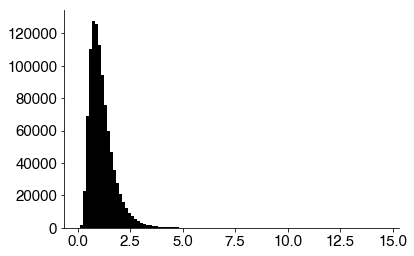

In [426]:
vals = np.random.lognormal(mean=0, sigma=0.5, size=1000000)
print('mean = {:.2f}, stdev = {:.2f}'.format(np.mean(vals), np.std(vals)))
offsets = [0, 5, 10, 25, 50, 75, 90, 95, 100]
display(pd.DataFrame(np.round(np.percentile(vals, offsets), 2), index=offsets, columns=['percentile']).T)

print('-' * 50, end='\n\n')

plt.hist(vals, bins=101, color='k')
plt.show()

mean = -0.00, stdev = 0.50


,0,5,10,25,50,75,90,95,100
percentile,-2.45,-0.82,-0.64,-0.34,-0.0,0.34,0.64,0.82,2.68


--------------------------------------------------



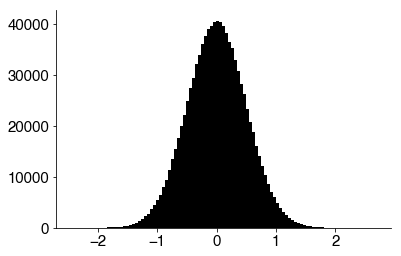

In [427]:
log_vals = np.log(vals)
print('mean = {:.2f}, stdev = {:.2f}'.format(np.mean(log_vals), np.std(log_vals)))
offsets = [0, 5, 10, 25, 50, 75, 90, 95, 100]
display(pd.DataFrame(np.round(np.percentile(log_vals, offsets), 2), index=offsets, columns=['percentile']).T)

print('-' * 50, end='\n\n')

plt.hist(log_vals, bins=101, color='k')
plt.show()

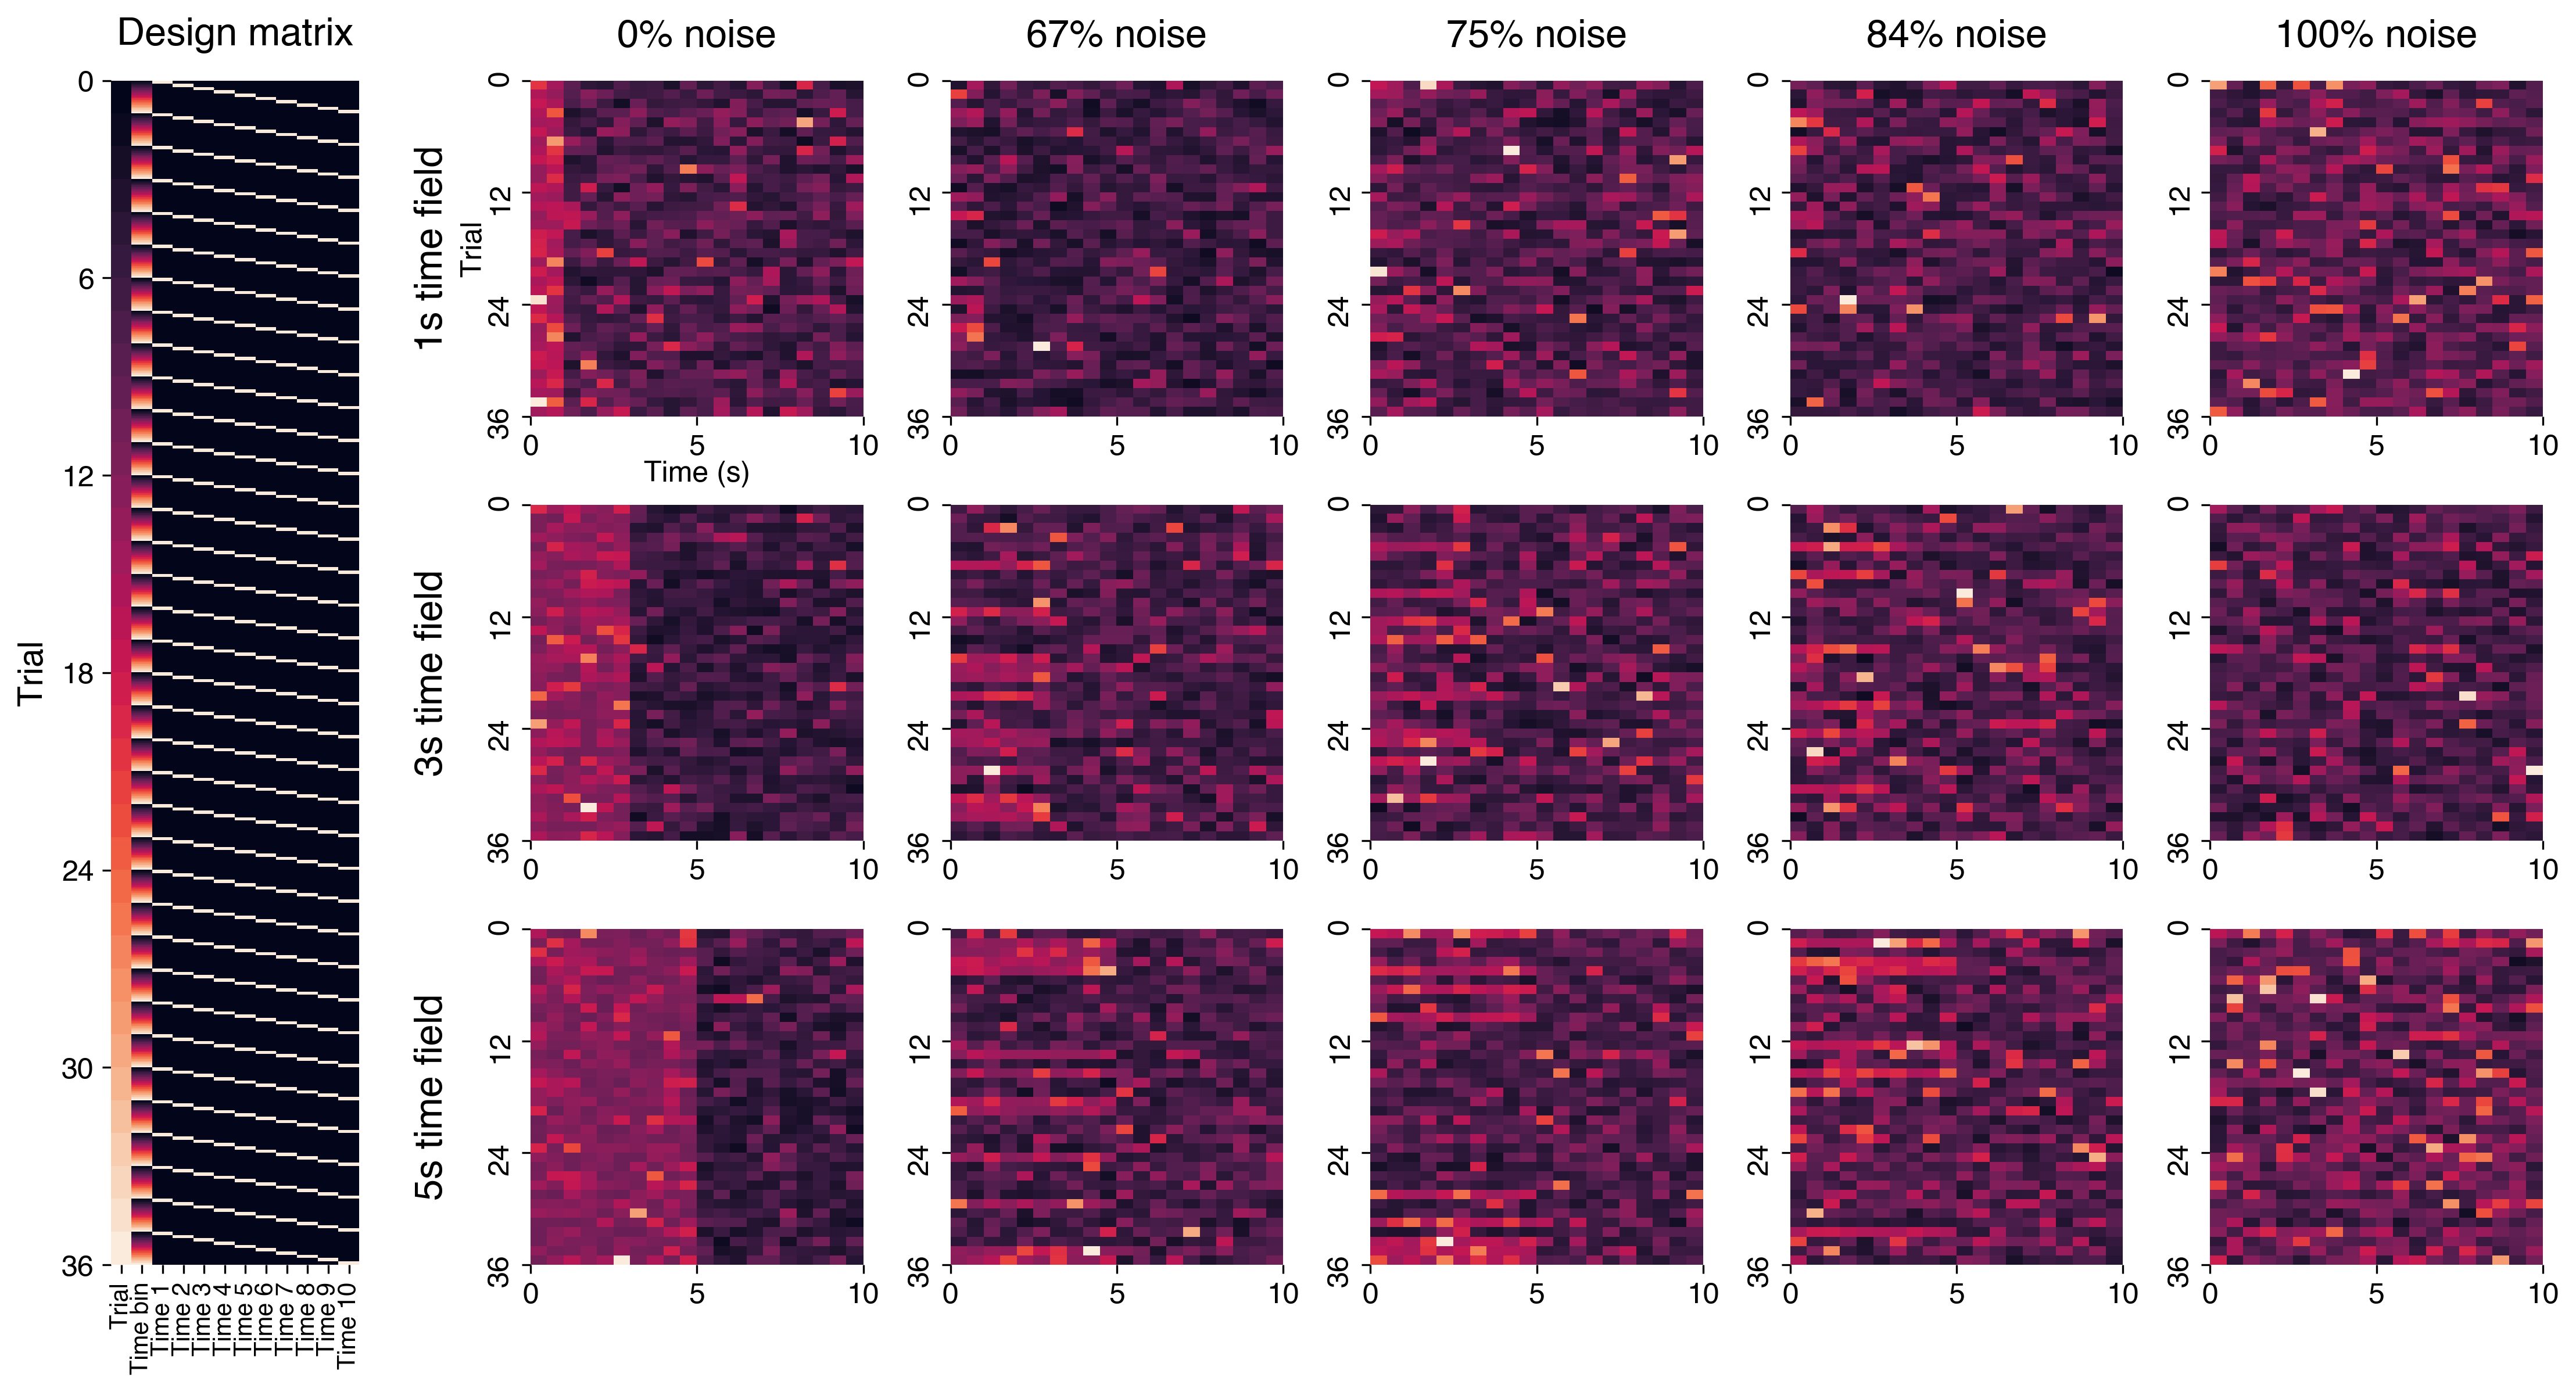

In [826]:
# Plot the simulated data.
plt.close()
fig = plt.figure(figsize=(18, 9), dpi=300)
grid_shp = (70, 145)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=75, colspan=15)]
for _x in range(len(field_sizes)):
    for _y in range(len(noise_props)):
        ax.append(plt.subplot2grid(grid_shp, (_x * 25, 25 + (_y * 25)), rowspan=20, colspan=20))

design_cols = ['trial', 'time_bin'] + time_cols
_df = sim_event_spikes[design_cols]

# Plot the design matrix.
iax = 0
ax[iax] = sns.heatmap(minmax_scale(_df, axis=0), vmin=0, vmax=1, cbar=False, ax=ax[iax])
ax[iax].set_xticks(np.arange(_df.shape[1]) + 0.5)
ax[iax].set_xticklabels([s.capitalize() for s in str_replace(design_cols, {'_': ' ', '-': ' '})], 
                        fontsize=font['tick']-2, rotation=90)
ax[iax].set_yticks(np.linspace(0, len(_df), 7))
ax[iax].set_yticklabels(np.arange(0, 37, 6, dtype=int), fontsize=font['tick'])
ax[iax].set_ylabel('Trial', fontsize=font['label'], labelpad=5)
ax[iax].annotate('Design matrix', (0.5, 1.03), xycoords='axes fraction', fontsize=font['fig'], ha='center')

# Plot the simulated time cells.
iax = 1
for _x in range(len(field_sizes)):
    for _y in range(len(noise_props)):
        ax[iax] = sns.heatmap(sim_spikes[(field_sizes[_x], noise_props[_y])], 
                              vmin=0, vmax=np.max(sim_spikes[(field_sizes[_x], noise_props[_y])]), 
                              cbar=False, ax=ax[iax])
        ax[iax].set_xticks(np.linspace(0, n_timebins, 3))
        ax[iax].set_xticklabels([0, 5, 10], fontsize=font['tick'])
        ax[iax].set_yticks(np.linspace(0, n_trials, 4))
        ax[iax].set_yticklabels(np.arange(0, 37, 12, dtype=int), fontsize=font['tick'])
        if iax == 1:
            ax[iax].set_xlabel('Time (s)', fontsize=font['tick'], labelpad=0)
            ax[iax].set_ylabel('Trial', fontsize=font['tick'], labelpad=0)
            
        if (iax - 1) < len(noise_props):
            ax[iax].annotate('{:.0%} noise'.format(noise_props[_y]), (0.5, 1.1), xycoords='axes fraction', fontsize=font['fig'], ha='center')
            
        if (iax - 1) % len(noise_props) == 0:
            ax[iax].annotate('{}s time field'.format(int(field_sizes[_x]/2)), (-0.35, 0.5), xycoords='axes fraction', fontsize=font['fig'], rotation=90, va='center')
        iax += 1
        
fig.show()

In [47]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM

<BarContainer object of 101 artists>

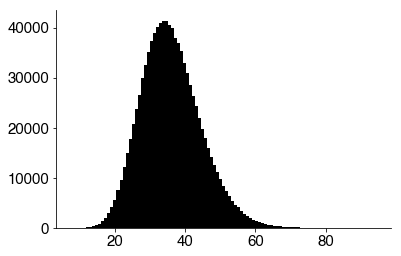

In [411]:
vals = np.random.chisquare(36, size=1000000)
counts, bin_edges = np.histogram(vals, bins=101)
plt.bar(np.mean((bin_edges[:-1], bin_edges[1:]), axis=0), counts, 
        width=np.median(np.diff(bin_edges)), color='k')

In [588]:
reload(time_bin_analysis)

<module 'time_cells.time_bin_analysis' from '/home1/dscho/code/projects/time_cells/time_bin_analysis.py'>

In [564]:
np.array(event_spikes.column_map['neurons'])

array(['2-0', '2-0.67', '2-0.84', '2-1', '6-0', '6-0.67', '6-0.84', '6-1',
       '10-0', '10-0.67', '10-0.84', '10-1'], dtype='<U7')

In [622]:
neuron = '2-0.75'
game_state = 'Delay1'
perm_method = 'circshift'
optimizer = 'lbfgs'

warnings.filterwarnings('ignore')
res = od([])
res[game_state] = time_bin_analysis.glm_fit(neuron, event_spikes, game_state, n_perm=1000, 
                                            regress_trial=True, perm_method=perm_method, optimizer=optimizer)
comp = time_bin_analysis.get_glm_res(res)
warnings.resetwarnings()

2-0.75 Delay1 circshift lbfgs 

 --------------------------------------------------



,subj_sess,neuron,gameState,testvar,reduced,full,llf_full,lr,z_lr,df,chi_pval,emp_pval,null_hist,icpt,time-2,time-3,time-4,time-5,time-6,time-7,time-8,time-9,time-10,trial-2,trial-3,trial-4,trial-5,trial-6,trial-7,trial-8,trial-9,trial-10,trial-11,trial-12,trial-13,trial-14,trial-15,trial-16,trial-17,trial-18,trial-19,trial-20,trial-21,trial-22,trial-23,trial-24,trial-25,trial-26,trial-27,trial-28,trial-29,trial-30,trial-31,trial-32,trial-33,trial-34,trial-35,trial-36
0,U518_ses0,2-0.75,Delay1,time,icpt,time,-543.81742,5.907543,1.404513,9.0,0.749135,0.087912,"[[10, 26, 41, 63, 75, 75, 108, 100, 78, 73, 63...",1.131627,-0.122524,-0.251691,-0.123693,-0.295121,-0.147247,-0.083405,-0.193985,-0.134884,-0.054012,-0.355855,-0.057388,-0.183449,0.018143,-0.076849,-0.111126,-0.084522,-0.21787,-0.206143,-0.170626,-0.079206,-0.011596,0.002776,0.000844,-0.257235,0.006439,-0.260142,-0.159884,-0.107145,-0.187152,-0.349955,-0.131629,-0.079339,-0.04008,-0.054163,-0.107954,-0.060661,-0.206278,-0.293515,-0.083536,-0.158595,-0.262605,-0.235721,-0.039624,-0.296135



 -------------------------------------------------- 



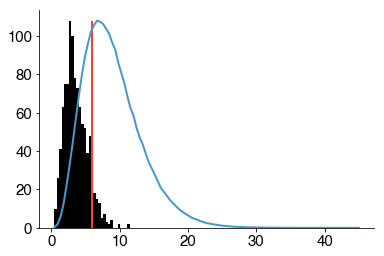

In [623]:
print(neuron, game_state, perm_method, optimizer, '\n\n', '-' * 50, end='\n\n')
display(comp)
print('\n', '-' * 50, '\n')

# Plot the empirical null distribution.
counts, bin_edges = comp.iloc[0]['null_hist']
bin_centers = np.mean((bin_edges[:-1], bin_edges[1:]), axis=0)
plt.bar(bin_centers, counts, width=np.median(np.diff(bin_edges)), color='k')
_max = np.max(counts)

# Plot the approximated chi-square distribution.
vals = np.random.chisquare(9, size=1000000)
counts, bin_edges = np.histogram(vals, bins=101)
counts = minmax_scale(counts, (0, _max))
bin_centers = np.mean((bin_edges[:-1], bin_edges[1:]), axis=0)
plt.plot(bin_centers, counts, linewidth=2, color=colors[0])

# Plot the observed value.
lr = (comp.query("(subj_sess=='{}') & (neuron=='{}') & (gameState=='{}') & (testvar=='time') & (full=='time')"
                 .format(subj_sess, neuron, game_state)).iloc[0]['lr'])
plt.vlines(lr, 0, _max, color=colors[1], linewidth=2)

plt.show()

In [812]:
reload(time_bin_analysis)

<module 'time_cells.time_bin_analysis' from '/home1/dscho/code/projects/time_cells/time_bin_analysis.py'>

In [ ]:
%lprun -f time_bin_analysis.ols_fit time_bin_analysis.ols_fit(neuron, event_spikes, game_state, n_perm=n_perm, regress_trial=regress_trial, perm_method=perm_method)

In [829]:
neuron = '2-0.75'
game_state = 'Delay1'
n_perm = 1000
regress_trial = True
perm_method = 'circshift'

start_time = time()

model_fits = od([])
model_fits[game_state] = time_bin_analysis.ols_fit(neuron, event_spikes, game_state, n_perm=n_perm, regress_trial=regress_trial, perm_method=perm_method)
lm_res = time_bin_analysis.get_model_pairs(model_fits)

print('Done in {:.1f}s'.format(time() - start_time))
start_time = time()

model_fits = od([])
model_fits[game_state] = time_bin_analysis.glm_fit(neuron, event_spikes, game_state, n_perm=n_perm, regress_trial=regress_trial, perm_method=perm_method)
glm_res = time_bin_analysis.get_model_pairs(model_fits)

print('Done in {:.1f}s'.format(time() - start_time))

Done in 33.2s
Done in 29.1s


In [831]:
lm_res

,subj_sess,neuron,gameState,testvar,reduced,full,llf_full,lr,z_lr,df,chi_pval,emp_pval,null_hist,Intercept,C(time_step)[T.1],C(time_step)[T.2],C(time_step)[T.3],C(time_step)[T.4],C(time_step)[T.5],C(time_step)[T.6],C(time_step)[T.7],C(time_step)[T.8],C(time_step)[T.9],C(trial)[T.2],C(trial)[T.3],C(trial)[T.4],C(trial)[T.5],C(trial)[T.6],C(trial)[T.7],C(trial)[T.8],C(trial)[T.9],C(trial)[T.10],C(trial)[T.11],C(trial)[T.12],C(trial)[T.13],C(trial)[T.14],C(trial)[T.15],C(trial)[T.16],C(trial)[T.17],C(trial)[T.18],C(trial)[T.19],C(trial)[T.20],C(trial)[T.21],C(trial)[T.22],C(trial)[T.23],C(trial)[T.24],C(trial)[T.25],C(trial)[T.26],C(trial)[T.27],C(trial)[T.28],C(trial)[T.29],C(trial)[T.30],C(trial)[T.31],C(trial)[T.32],C(trial)[T.33],C(trial)[T.34],C(trial)[T.35],C(trial)[T.36]
0,U518_ses0,2-0.75,Delay1,time,icpt,time,-471.1198,16.970685,1.44042,9.0,0.049177,0.087912,"[[9, 22, 29, 66, 68, 87, 82, 99, 86, 63, 76, 5...",3.052023,-0.313768,-0.605454,-0.316579,-0.695364,-0.372552,-0.217734,-0.479786,-0.343337,-0.143065,-0.809426,-0.150766,-0.453082,0.049492,-0.199961,-0.284313,-0.219095,-0.529217,-0.503572,-0.424041,-0.205853,-0.031167,0.007515,0.002282,-0.613135,0.017464,-0.619202,-0.399426,-0.274663,-0.461399,-0.798219,-0.333402,-0.206187,-0.106203,-0.142522,-0.276628,-0.159108,-0.503869,-0.687606,-0.216645,-0.396454,-0.62433,-0.567683,-0.10502,-0.69288


In [832]:
glm_res

,subj_sess,neuron,gameState,testvar,reduced,full,llf_full,lr,z_lr,df,chi_pval,emp_pval,null_hist,icpt,time-2,time-3,time-4,time-5,time-6,time-7,time-8,time-9,time-10,trial-2,trial-3,trial-4,trial-5,trial-6,trial-7,trial-8,trial-9,trial-10,trial-11,trial-12,trial-13,trial-14,trial-15,trial-16,trial-17,trial-18,trial-19,trial-20,trial-21,trial-22,trial-23,trial-24,trial-25,trial-26,trial-27,trial-28,trial-29,trial-30,trial-31,trial-32,trial-33,trial-34,trial-35,trial-36
0,U518_ses0,2-0.75,Delay1,time,icpt,time,-543.81742,5.907543,1.563879,9.0,0.749135,0.07992,"[[4, 10, 22, 51, 68, 59, 62, 81, 78, 80, 80, 5...",1.131627,-0.122524,-0.251691,-0.123693,-0.295121,-0.147247,-0.083405,-0.193985,-0.134884,-0.054012,-0.355855,-0.057388,-0.183449,0.018143,-0.076849,-0.111126,-0.084522,-0.21787,-0.206143,-0.170626,-0.079206,-0.011596,0.002776,0.000844,-0.257235,0.006439,-0.260142,-0.159884,-0.107145,-0.187152,-0.349955,-0.131629,-0.079339,-0.04008,-0.054163,-0.107954,-0.060661,-0.206278,-0.293515,-0.083536,-0.158595,-0.262605,-0.235721,-0.039624,-0.296135


In [749]:
print(neuron, game_state, model, n_perm, perm_method)
model_fits['obs']['time'].summary2()

print('-' * 50, '\n', 'LR test', end='\n\n')
print(model_fits['obs']['time'].llf, model_fits['obs']['icpt'].llf, time_bin_analysis.lr_test(model_fits['obs']['icpt'], model_fits['obs']['time']))



2-0.75 Delay1 linear 2 circshift
-------------------------------------------------- 
 LR test

-471.119800034964 -479.60514241947476 (16.970684769021545, 9, 0.04917703363214046)


In [739]:
# anova_lm(ols('Q("{}") ~ C(time_step) + C(trial)'.format(neuron), data=df).fit())
_res = ols('Q("{}") ~ 1 + C(time_step) + C(trial)'.format(neuron), data=df).fit()

In [724]:
_res.compare_lr_test(ols('Q("{}") ~ 1 + C(trial)'.format(neuron), data=df).fit())

(16.970684769021545, 0.04917703363214046, 9.0)

In [624]:
print(neuron, game_state, perm_method, optimizer)

# Sum spikes across time bins within each time step, within each trial.
df = event_spikes.event_spikes.copy()
df = pd.concat((df.groupby(['trial', 'time_step']).agg({neuron: np.sum}),
                df.groupby(['trial', 'time_step']).agg({icpt: np.mean for icpt in event_spikes.column_map['icpt']}),
                df.groupby(['trial', 'time_step']).agg({time: np.mean for time in event_spikes.column_map['time']}),
                df.groupby(['trial', 'time_step']).agg({trial: np.mean for trial in event_spikes.column_map['trial']})),
               axis=1).reset_index()

# Two-way ANOVA
res_full = ols('Q("{}") ~ C(time_step) + C(trial)'.format(neuron), data=df).fit()
res_partial = ols('Q("{}") ~ C(trial)'.format(neuron), data=df).fit()
aov_res = anova_lm(res_full)

print('-' * 50, '\n', 'Two-way ANOVA', end='\n\n')
print(res_full.summary(), end='\n\n')
display(aov_res)

print('-' * 50, '\n', 'LR test', end='\n\n')
print(res_full.llf, res_partial.llf, time_bin_analysis.lr_test(res_partial, res_full))

# # One-way repeated measures ANOVA
# raov_res = AnovaRM(data=event_spikes.event_spikes, depvar=neuron, subject='trial', within=['time_step'], aggregate_func=np.mean).fit()
# print('\n\n', '-' * 50, '\n', 'Repeated measures ANOVA', end='\n\n')
# display(raov_res.anova_table)

2-0.75 Delay1 circshift lbfgs
-------------------------------------------------- 
 Two-way ANOVA

                            OLS Regression Results                            
Dep. Variable:            Q("2-0.75")   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.8740
Date:                Sat, 13 Mar 2021   Prob (F-statistic):              0.700
Time:                        17:26:47   Log-Likelihood:                -471.12
No. Observations:                 360   AIC:                             1032.
Df Residuals:                     315   BIC:                             1207.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

,df,sum_sq,mean_sq,F,PR(>F)
C(time_step),9.0,13.937814,1.548646,1.689435,0.090574
C(trial),35.0,21.313315,0.608952,0.664313,0.928741
Residual,315.0,288.749401,0.916665,NaN,NaN


-------------------------------------------------- 
 LR test

-471.119800034964 -479.60514241947476 (16.970684769021545, 9, 0.04917703363214046)
